In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

import pickle
import os
import sys
import warnings
import ast

plt.style.use('ggplot')
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker



warnings.filterwarnings('ignore')
pd.options.display.max_columns=200


path=r"C:\Users\berid\python\Shell Stations Project"

In [2]:
df=pd.read_csv('Shell_Gas_Stations (cleaned).csv')

df.sample()

,URL,Country,State,City,Station,Fuels,EV Charging Points,Opening Hours,Services,More At Location,Lat,Lon
17869,https://find.shell.com/us/fuel/10003366-312-we...,United States,Texas,TAYLOR,312 WEST LAKE DRIVE,[{'Fuel': 'Shell V-Power NiTRO+ Premium Gasoli...,0.0,"[{'Weekday': 'Monday', 'Hours': 24}, {'Weekday...",Cash machine|Mobile Payment|Shop|Toilet,ATM-IN|Air|Credit Card|Credit card - General|G...,30.582522,-97.413869


In [3]:
df['Fuels']=df['Fuels'].apply(ast.literal_eval)
df['Opening Hours']=df['Opening Hours'].apply(ast.literal_eval)

# EDA

##### Define world, cities and add important data to df

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world=world[world['name'] != "Antarctica"]
world['Area']=world.to_crs(epsg=6933).geometry.area/10**6
world['name']=world['name'].map({'United States of America':'United States','Dominican Rep.':'Dominican Republic','Mauritania':'Mauritius','Turkey':'Türkiye'}).fillna(world['name'])

In [5]:
cities=pd.read_csv(os.path.join(path,'biggest_cities','worldcities.csv'))
cities['pop_size']=pd.qcut(cities['population'],q=10,labels=False)/100

cities['country']=cities['country'].map({'Macau':'Macao','Turkey':'Türkiye'}).fillna(cities['country'])

In [6]:
grouped=cities.groupby('country')['population'].sum().reset_index()
df=df.merge(grouped,how='left',left_on='Country',right_on='country').drop(columns='country').rename(columns={'population':'Total Urban Population'})

df=df.merge(world[['name','Area']],how='left',left_on='Country',right_on='name').drop(columns='name').rename(columns={'Area':'Total Country Area (sqkm)'})
df['Total Country Area (sqkm)']=df.apply(lambda x: {'Hong Kong': 1106, 'Macao': 32.9, 'Singapore': 728.6}.get(x['Country'], x['Total Country Area (sqkm)']), axis=1)

In [7]:
states=geopandas.read_file(r"C:\Users\berid\python\geopandas\USA States\s_22mr22.shp")
remote_states = ['HI', 'AK', 'PR', 'AS', 'GU', 'VI', 'MP', 'FM', 'PW', 'MH']
states=states[states['STATE'].isin(remote_states)==False]

In [8]:
df['Total Urban Population Per Station'] = df.groupby('Country')['Total Urban Population'].transform('mean') / df.groupby('Country')['URL'].transform('count')


##### Shell locations and city population dispersion in the world

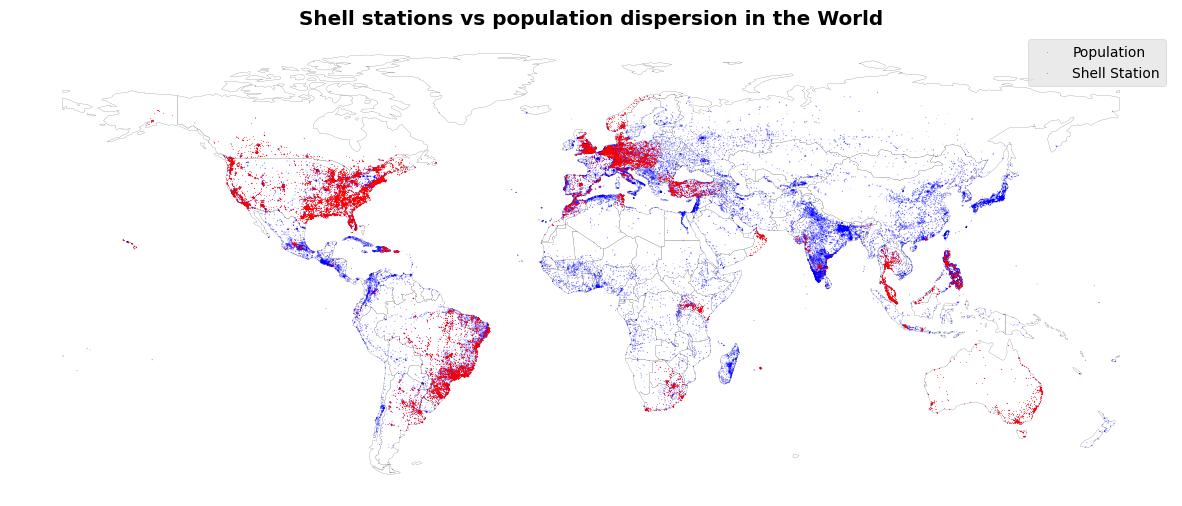

In [9]:
fig,ax=plt.subplots(figsize=(15,15))
world.plot(ax=ax,color='White',ec='Black',lw=0.1)
cities.plot.scatter(ax=ax,x='lng',y='lat',color='Blue',s='pop_size',alpha=.5,label='Population')
df.plot.scatter(ax=ax,x='Lon',y='Lat',s=0.1,c='Red',alpha=.5,label='Shell Station')

ax.set_title('Shell stations vs population dispersion in the World',fontweight='bold')
ax.axis('off')
plt.show()

##### 10 countries with the highest poplulation, where Shell is not operating

In [10]:
g=cities.groupby('country')['population'].sum()
print('Biggest countries by urban population:')

g[g.index.isin(df['Country'].unique())==False].sort_values(ascending=False).head(10).apply(lambda x:f"{x:,.0f}")

#China, Japan, Russia, South Korea, Vietnam would be profitable countries for Shell

Biggest countries by urban population:


country
China           1,401,104,393
Japan             184,539,032
Russia            107,402,025
Pakistan           76,296,822
Nigeria            69,764,582
Iran               63,585,422
Korea, South       61,054,650
Egypt              58,391,935
Vietnam            52,372,188
Bangladesh         45,725,281
Name: population, dtype: object

##### Shell locations and city population dispersion in the USA

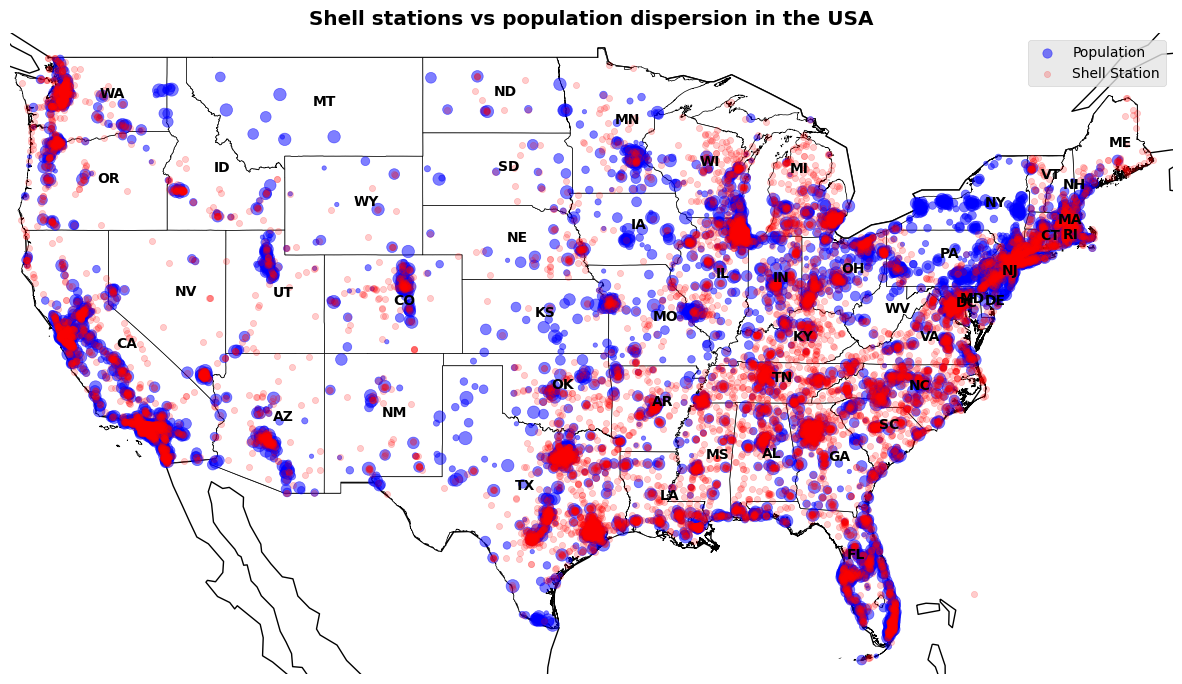

In [11]:
fig,ax=plt.subplots(figsize=(15,15))
world.plot(ax=ax,color='White',ec='Black',lw=1)
states.plot(ax=ax,color='White',ec='Black',lw=0.5)
cities[cities['country']=='United States'].plot.scatter(ax=ax,x='lng',y='lat',color='Blue',s=cities[cities['country']=='United States']['pop_size']*1000,alpha=.5,label='Population')
df[df['Country']=='United States'].plot.scatter(ax=ax,x='Lon',y='Lat',c='Red',alpha=.2,label='Shell Station')

ax.set_title('Shell stations vs population dispersion in the USA',fontweight='bold')
ax.set_xlim([-125, -66]) 
ax.set_ylim([24, 50])    

for i in range(len(states)):
    ax.text(states['LON'].iloc[i],states['LAT'].iloc[i],states['STATE'].iloc[i],fontweight='bold')

ax.axis('off')
plt.show()

In [12]:
# Not Many Stations in NY, PA, MT, IA, KS

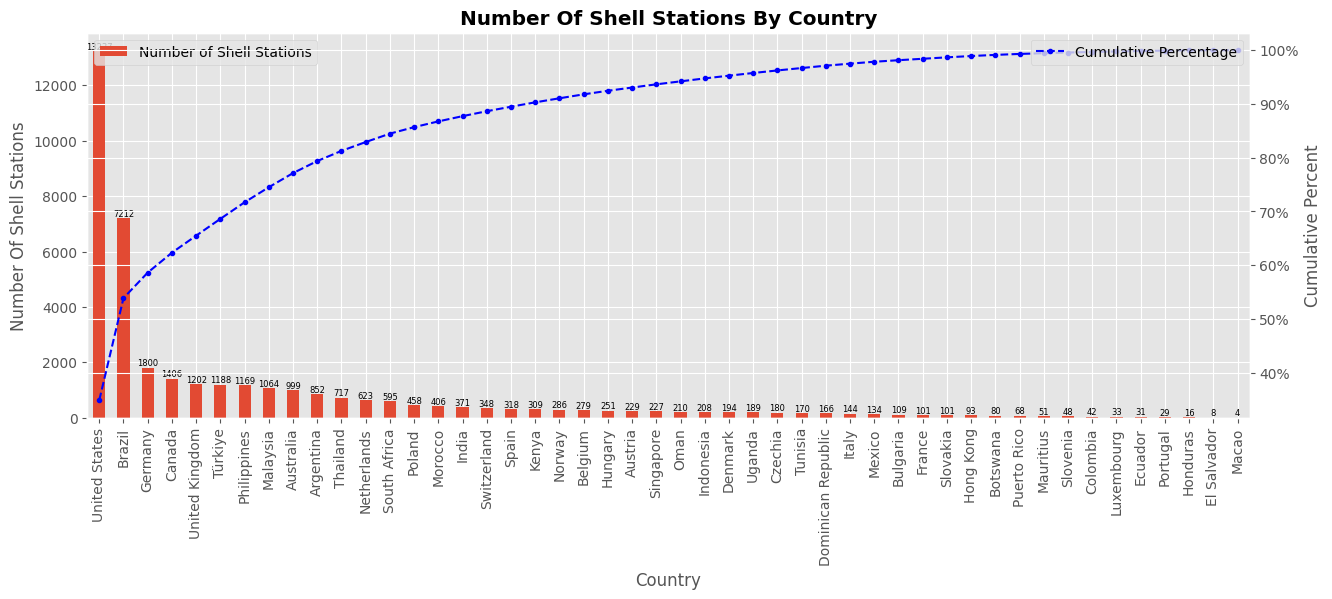

In [13]:
grouped=df.groupby('Country')['URL'].count().sort_values(ascending=False)
cumulative_percent=grouped.cumsum()/grouped.sum()

fig,ax=plt.subplots(figsize=(15,5))
ax2=ax.twinx()
ax2.yaxis.set_major_formatter(PercentFormatter(1))

grouped.plot.bar(ax=ax,label='Number of Shell Stations')
ax2.plot(grouped.index, cumulative_percent,color='Blue',marker='.',ls='--',label='Cumulative Percentage')
ax.set_title('Number Of Shell Stations By Country',fontweight='bold')
ax.set_ylabel('Number Of Shell Stations')
ax2.set_ylabel('Cumulative Percent')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

for i in range(len(grouped)):
    ax.text(i,grouped.iloc[i],grouped.iloc[i],size=6,ha='center',va='bottom')
    

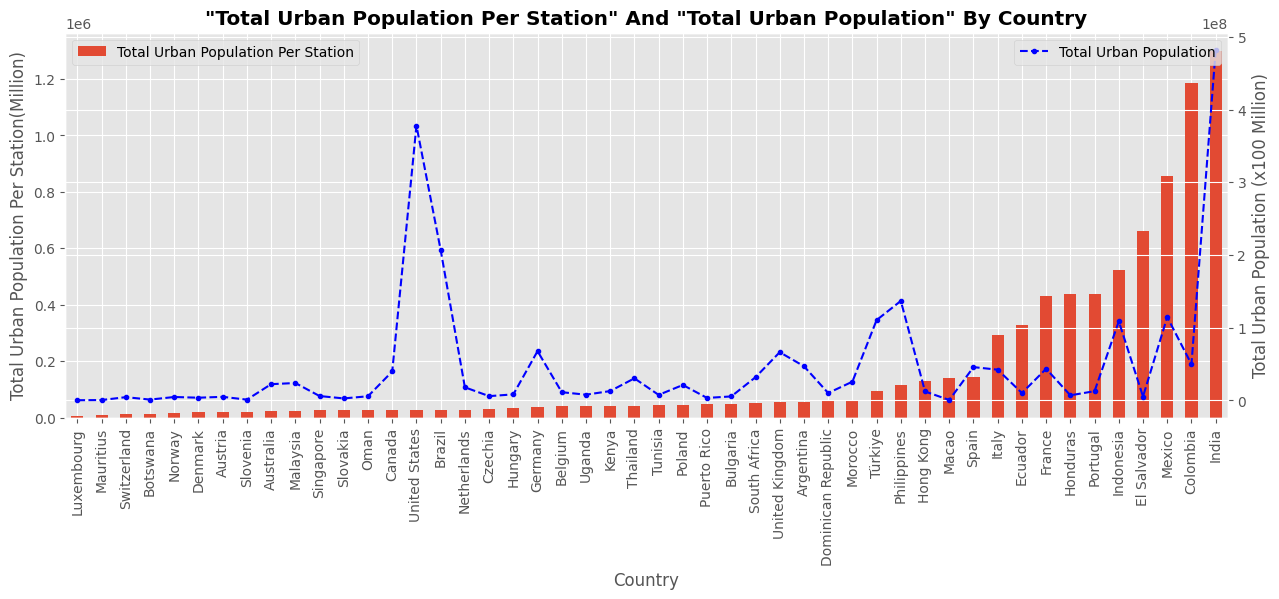

In [14]:
grouped=df.groupby('Country')[['Total Urban Population','Total Urban Population Per Station']].mean().sort_values(by='Total Urban Population Per Station',ascending=True)

fig,ax=plt.subplots(figsize=(15,5))
ax2=ax.twinx()
grouped['Total Urban Population Per Station'].plot.bar(ax=ax,x='Country')
grouped['Total Urban Population'].plot(ax=ax2,color='Blue',ls='--',marker='.')
ax.set_title('"Total Urban Population Per Station" And "Total Urban Population" By Country',fontweight='bold')
ax.set_ylabel('Total Urban Population Per Station(Million)')
ax2.set_ylabel('Total Urban Population (x100 Million)')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [15]:
# number of Total Urban Population Per Station is low in Australia, Malaysia, Brazil, United States, Germany, Thaliand, UK, United States, Turkey, Philippines

In [16]:
cities['City_ID']=cities['city'].str.upper()+'_'+cities['lng'].astype(int).astype(str)+'_'+cities['lat'].astype(int).astype(str)
df['City_ID']=df['City'].astype(str)+'_'+df['Lon'].astype(int).astype(str)+'_'+df['Lat'].astype(int).astype(str)


df=df.merge(cities[['City_ID','population']],how='left',on='City_ID').sort_values('population',ascending=False).drop_duplicates(subset='URL',keep='first').sort_index()

df['City Population Per Station'] = df.groupby('City_ID')['population'].transform('mean') / df.groupby('City_ID')['URL'].transform('count')


df=df.drop(columns='City_ID')
df=df.rename(columns={'population':'City Population'})

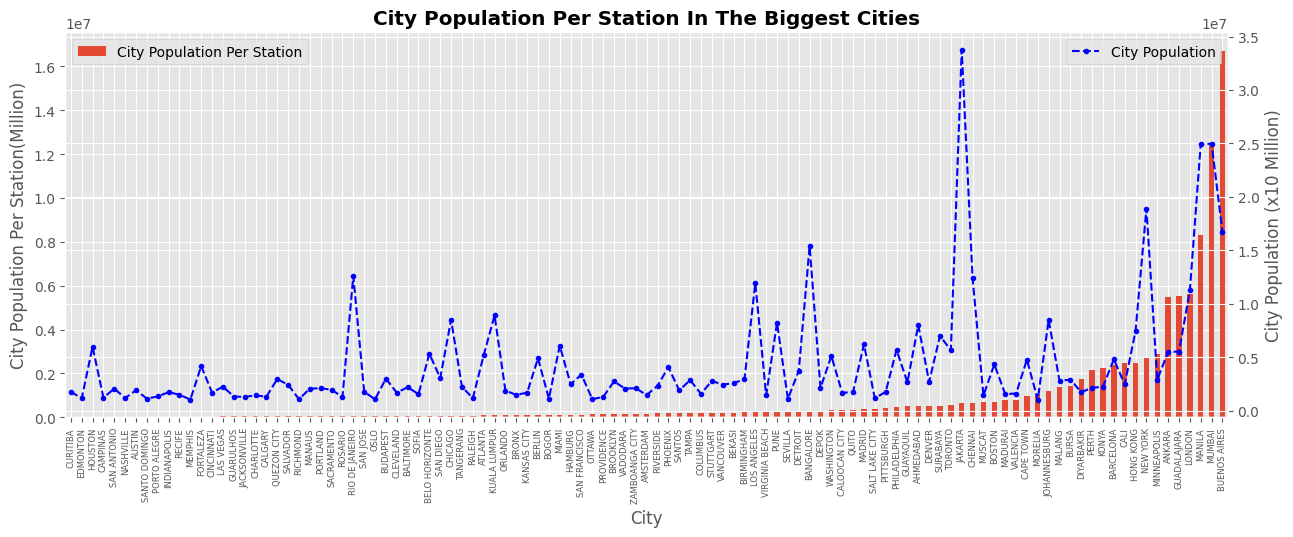

In [17]:
grouped=df[df['City Population']>=10**6].groupby('City')[['City Population','City Population Per Station']].mean().reset_index().sort_values('City Population Per Station',ascending=True)


fig,ax=plt.subplots(figsize=(15,5))
ax2=ax.twinx()
grouped.plot.bar(ax=ax,x='City',y='City Population Per Station')
grouped.plot(ax=ax2,x='City',y='City Population', color='Blue',ls='--',marker='.')
ax.set_title('City Population Per Station In The Biggest Cities',fontweight='bold')
ax.set_ylabel('City Population Per Station(Million)')
ax2.set_ylabel('City Population (x10 Million)')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_xticklabels(grouped['City'],size=6)
plt.show()

In [18]:
# Jakarta has urban population of 35 million (including metropolitan area). Still, population per station is low. This city is well managed by Shell
# Same could be said about Bangalore, Rio De Janiero, Los Angeles, New York


# Population per station is high in Philadelphia, Mumbai, Miami and Buenos Aires. Maybe, these cities need more Shell Stations ? 

##### EV Charing Points Analysis

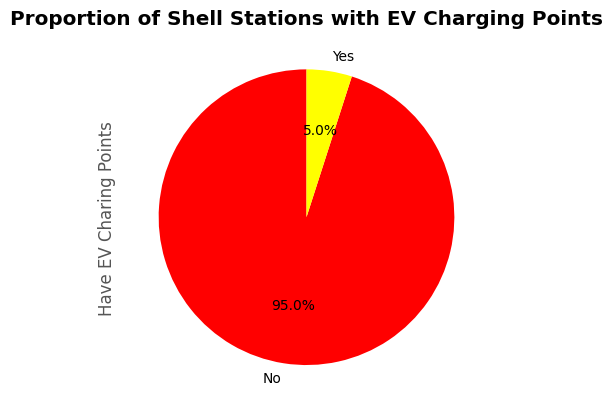

In [19]:
proportions = df['EV Charging Points'].apply(lambda x: 'Yes' if pd.notna(x) and x != 0 else 'No').value_counts()

plt.figure()
proportions.plot.pie(autopct='%1.1f%%', startangle=90, colors=['Red', 'Yellow'])
plt.title('Proportion of Shell Stations with EV Charging Points', fontweight='bold')
plt.ylabel('Have EV Charing Points')
plt.show()

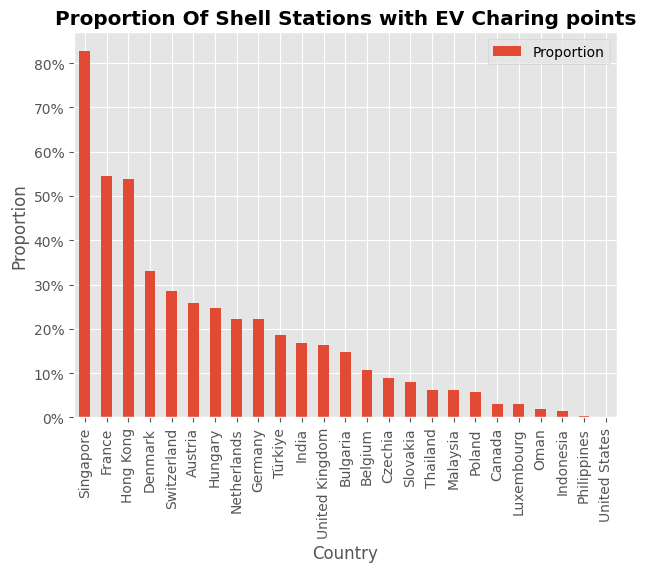

In [20]:
grouped = df.groupby(
    ['Country', df['EV Charging Points'].apply(lambda x: 'Yes' if pd.notna(x) and x != 0 else 'No')]
)['URL'].count().reset_index()

# Now calculate the proportions
grouped['Proportion'] = grouped.groupby('Country')['URL'].transform(lambda x: x / x.sum())
grouped=grouped[grouped['EV Charging Points']=='Yes'].sort_values(by='Proportion',ascending=False)


fig,ax=plt.subplots(figsize=(7,5))
grouped.plot.bar(ax=ax,x='Country',y='Proportion')
ax.set_title('Proportion Of Shell Stations with EV Charing points',fontweight='bold')
ax.set_ylabel('Proportion')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
plt.show()

##### Analizing stations' services

In [21]:
"""average_distances=[]

for i,(country, state, city) in enumerate(zip(df['Country'],df['State'],df['City']),start=1):
    if pd.isna(state):
        filtered=df.query("Country==@country and City==@city")
    else:
        filtered=df.query("Country==@country and State==@state and City==@city")

    distances=[]
    for lat1, lon1 in zip(filtered['Lat'],filtered['Lon']):
        for lat2, lon2 in zip(filtered['Lat'],filtered['Lon']):
            if lat1!=lat2 and lon1!=lon2:
                distance=np.sqrt(np.square(lat2-lat1)+np.square(lon2-lon1))*111.1
                distances.append(distance)

    average_distance=np.mean(distances)
    average_distances.append(average_distance)

    print(i,end='\r')

pickle.dump(average_distances,open(os.path.join(path,'average_distances.pickle'),'wb'))"""
average_distances=pickle.load(open(os.path.join(path,'average_distances.pickle'),'rb'))

In [22]:
df['Average Distance Between Stations (km)']=average_distances

In [23]:
#average distance between stations (km) within city 

df.groupby('Country')['Average Distance Between Stations (km)'].median().sort_values(ascending=False)

Country
Uganda                55.530456
Kenya                 53.431516
India                 17.726237
Ecuador               11.854129
Morocco               10.995805
Indonesia             10.096605
Oman                   9.918685
Colombia               9.796461
Thailand               9.760605
Dominican Republic     8.951550
Bulgaria               8.185487
Canada                 7.606291
Malaysia               7.254804
Tunisia                7.005106
Türkiye                6.959807
Mauritius              6.832478
United States          6.797899
Poland                 6.794276
United Kingdom         6.692653
Germany                6.027326
Honduras               5.787452
Italy                  5.710482
Botswana               5.526239
Brazil                 4.968984
Norway                 4.966316
South Africa           4.850117
Mexico                 4.794676
Puerto Rico            4.630665
Argentina              4.480787
Philippines            4.442783
Spain                  4.349277


In [24]:
all_services=[]
for line in df['Services']:
    try:
        services=line.split('|')
    except:
        continue
    
    for service in services:
        all_services.append(service.strip())

#most common services at Shell gas stations
for service in pd.Series(all_services).unique():
    proportion=df[df['Services'].apply(lambda x:service in x if isinstance(x,str) else False)].shape[0]/df.shape[0]
    proportion=round(proportion*100,1)
    print(f'Percentage of stations which have {service} : {proportion} %')

Percentage of stations which have Cash machine : 16.7 %
Percentage of stations which have Toilet : 32.6 %
Percentage of stations which have Mobile Payment : 30.1 %
Percentage of stations which have Shop : 29.4 %
Percentage of stations which have Car Wash : 14.9 %
